In [1]:
import os
import pandas as pd
import numpy as np


from joblib import Parallel, delayed

import androguard
from androguard.misc import AnalyzeAPK, APK

from sklearn.model_selection import GridSearchCV 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

import matplotlib.pyplot as plt

In [2]:
def analyze_APK(filename, path):
    dict_entry = {}
    file = os.path.join(path, filename)
    try:
        a = APK(file)
    except:
        print(filename)
        dict_entry[filename] = []
        return dict_entry
    

    features = a.get_activities()
    features = features + a.get_permissions()
    features = features + a.get_services()
    features = features + a.get_providers()
    if(a.is_multidex()): features = features + ['is_multidex']
    else: features = features + ['is_not_multidex']
    if(a.is_valid_APK()): features = features + ['is_valid_APK']
    else: features = features + ['is_not_valid_APK']

    dict_entry[filename] = features

    return dict_entry

In [3]:
def get_unique_features(data_dict):
    unique_tags_set = set({})

    for key in data_dict:
        unique_tags_set.update(set(data_dict[key]))
    
    unique_tags = list(unique_tags_set)
    return unique_tags


def get_features(list_features, unique_features):
    features = np.zeros(len(unique_features))
    for feature in list_features:
        if feature in unique_features:
            ind = unique_features.index(feature)
            features[ind] = 1
    return features

# Extract features from train data

In [4]:
path_test = os.path.join(os.getcwd(), "ch02-test")
filenames_test = os.listdir(path_test)

In [5]:
%%time

data_test_list = (Parallel(n_jobs = -1)(delayed(analyze_APK)(filename, path_test) for filename in filenames_test))

Requested API Level could not be found, using 10 instead
Requested API Level could not be found, using 19 instead
Requested API Level could not be found, using 19 instead
Requested API Level could not be found, using 10 instead
Requested API Level could not be found, using 19 instead
Requested API Level could not be found, using 10 instead
Requested API Level could not be found, using 10 instead
Requested API Level could not be found, using 19 instead
Requested API Level could not be found, using 19 instead
Requested API Level could not be found, using 10 instead
Name 'android:versionName' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:minSdkVersion' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:targetSdkVersion' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix

Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:theme' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:theme' starts with 'android:' prefix! Th

Requested API Level could not be found, using 10 instead
Requested API Level could not be found, using 10 instead
Requested API Level could not be found, using 10 instead
Name 'android:versionName' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:minSdkVersion' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:targetSdkVersion' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing p

Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:theme' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:configChanges' starts with 'android:' prefix! The Manifest seems to be broken? Removing prefix.
Name 'android:name' starts with 'android:' prefix! The

CPU times: user 14.7 s, sys: 2.35 s, total: 17.1 s
Wall time: 30.6 s


In [6]:
data_test = {}

for entry in data_test_list:
    key = list(entry.keys())[0]
    data_test[key] = entry[key]

In [7]:
unique_features = get_unique_features(data_test)

In [8]:
for key in data_test:
    data_test[key] = get_features(data_test[key], unique_features)

In [9]:
dataframe_test = pd.DataFrame.from_dict(data_test, orient='index', columns = unique_features)

In [10]:
dataframe_test.to_csv("test_features_cluster_1.csv")

# Read data

In [11]:
data_test1 = pd.read_csv("test_features_cluster_1.csv", index_col = 0)

test = data_test1.values

# Calculate model parameters

In [17]:
mygrid = {}

for c in range(4, 20, 2):
    cluster = KMeans(n_clusters=c).fit(test)
    mygrid[c] = silhouette_score(test, labels=cluster.labels_)

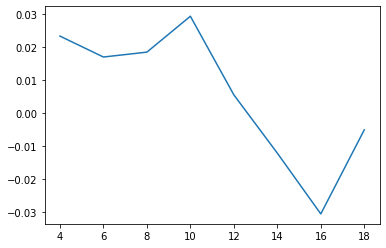

In [18]:
plt.plot(mygrid.keys(),mygrid.values())

# Model

In [ ]:
kmeans = KMeans(n_clusters = 10).fit(test)

In [ ]:
preds = kmeans.labels_

In [ ]:
pd.Series(preds, index = data_test1.index).to_csv("test_cluster_1.csv", header = None)